In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import re
import nltk
import string
import sys
from prettytable import PrettyTable

from wordcloud import STOPWORDS
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from xgboost import XGBClassifier,plot_tree
import pydotplus

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,mean_squared_error

from sklearn import metrics

from IPython.display import display
#import graphviz

import warnings
warnings.filterwarnings("ignore")

Our dataset can be found on Kaggle via this link:
https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus?resource=download


Other sources: There are a few more I need to add...
https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
    
https://medium.com/@tenzin_ngodup/simple-text-classification-using-random-forest-fe230be1e857

https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

Text Classification Using Naive Bayes.pdf Neba Nfonsang


Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

In [2]:
#Import data

data = pd.read_csv('/Users/Lumin/Desktop/mental_health.csv', skipinitialspace=True)

#data = pd.read_csv('mental_health.csv', skipinitialspace=True)

data

text  label
0      dear american teens question dutch person hear...      0
1      nothing look forward lifei dont many reasons k...      1
2      music recommendations im looking expand playli...      0
3      im done trying feel betterthe reason im still ...      1
4      worried  year old girl subject domestic physic...      1
...                                                  ...    ...
27972  posting everyday people stop caring  religion ...      0
27973  okay definetly need hear guys opinion ive pret...      0
27974  cant get dog think ill kill myselfthe last thi...      1
27975  whats point princess bridei really think like ...      1
27976  got nudes person might might know snapchat do ...      0

[27977 rows x 2 columns]

In [3]:
#Check for null values

data.isna().sum()

#Only 2 rows with NA values, dropping both

data = data.dropna()
data.isna().sum()

text     0
label    0
dtype: int64

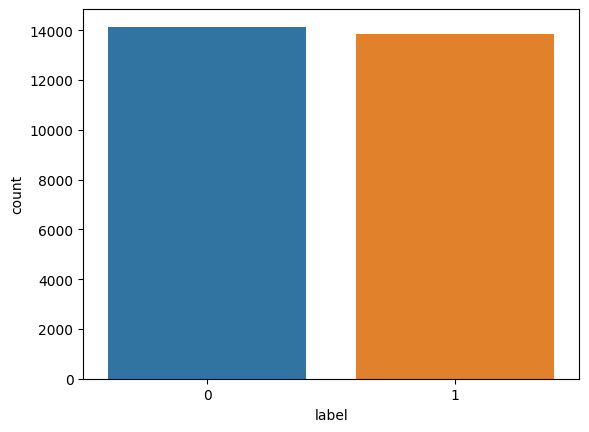

In [4]:
#Check balance of target variable 'label' (1 is concerning, 0 is not)

sns.countplot(x=data['label'])
plt.show()

In [5]:
#Checking text to compare to cleaned text

pd.options.display.max_colwidth = 500
data['text'].head(25)

0                                                                                                                                                                                                                                                                                                                                                                                 dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like  right guys learn math
1                                                                                                                                                                                                                                                                                                                                                                                                   nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want 

In [6]:
#Removing stopwords

stopwords = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
data['text']

0                                                                                                                                                                                                                                                                                                                                                                                     dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math
1                                                                                                                                                                                                                                                                                                                                                                                                             nothing look forward lifei dont many reasons keep going feel like nothing keeps going next da

In [7]:
#Checking stopwords were removed

pd.options.display.max_colwidth = 500
data['text'].head(25)

0                                                                                                                                                                                                                                                                                                                                                                                  dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math
1                                                                                                                                                                                                                                                                                                                                                                                                          nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day make

In [8]:
#Remove any 'words' longer then 20 characters

def removelongwords(string, k=20):
    split_string = string.split()
    words = [x for x in split_string if len(x) < k]
    words = ' '.join(words)
    return words


data['text'] = data['text'].apply(lambda x: removelongwords(x))
#data

20 characters an estimate, this sentiments not pulled form professional writing; personal or social media is often full of nonsensical expressions.

In [9]:
#Separating categories for word clouds

good = data.loc[data.label == 1] 
bad = data.loc[data.label == 0] 

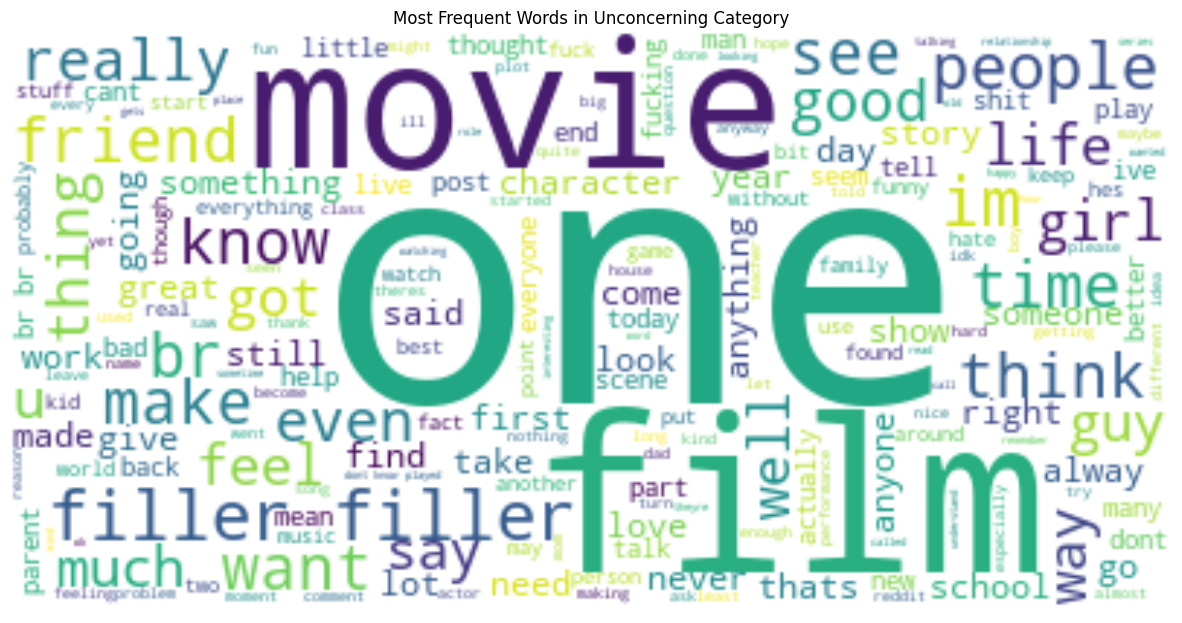

In [10]:
#'Good' word wordcloud

text = " ".join(i for i in bad.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words in Unconcerning Category')
plt.show()

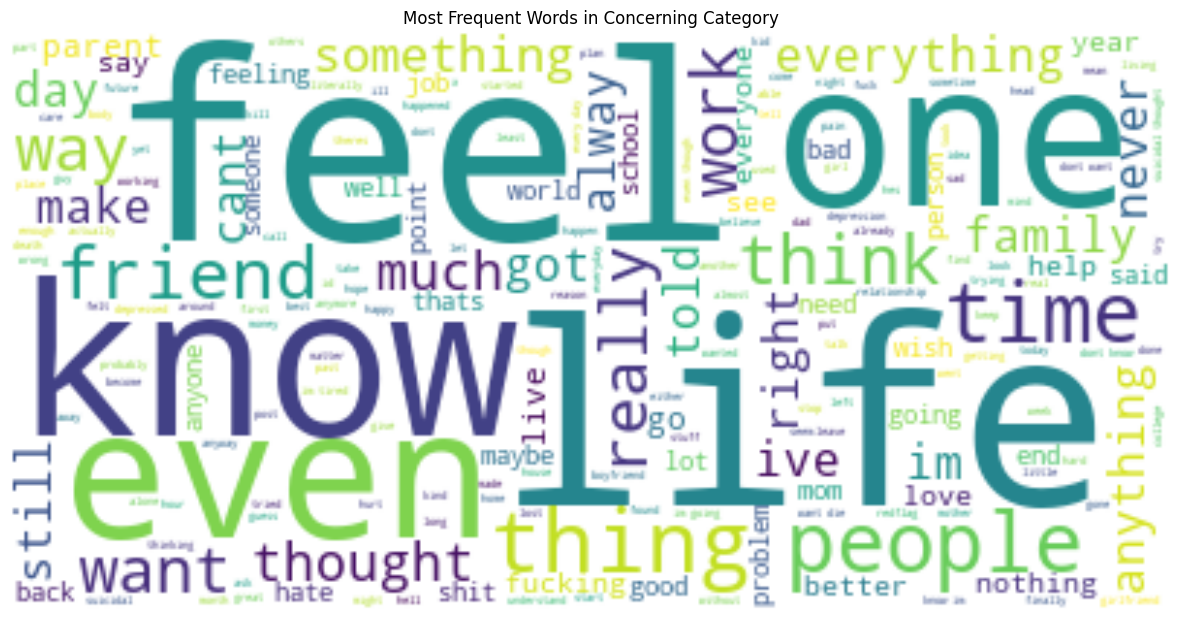

In [11]:
#'Bad' word wordcloud

text = " ".join(i for i in good.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Words in Concerning Category')
plt.axis("off")
plt.show()

In [12]:
#split into features/target

features = data['text']
target = data['label']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"],test_size=0.3)
print(X_train.shape, 'X_train')
print(len(y_train), 'y_train')
print(X_test.shape, 'X_test')
print(len(y_test),'y_test' )

(19582,) X_train
19582 y_train
(8393,) X_test
8393 y_test


In [14]:
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", min_df=10, max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train) 
print(X_train_tfidf.toarray().shape)
X_test_tfidf= tfidf.transform(X_test) 
print(X_test_tfidf.toarray().shape)
#Setting up Pretty table
pretty_table = PrettyTable()
pretty_table.field_names = ['Model', 'Test Accuracy']

(19582, 15844)
(8393, 15844)


The “term frequency-inverse document frequency” considers the most common term and minimizes the weight of words with a high count and makes the less common terms have a greater impact. This is the way to perform numerical analysis on strings and maintain their relevance. 


Naïve Bayes:

When the independent assumption holds then this classifier gives outstanding accuracy and works well with high dimensionality, easy because it only calculates probability. BernoulliNB function as this is the best algorithm for the probability of dice. Think of each TFIDF vectorized document as a dice game, considering that each word maintains its importance per document like each die, either it was a winning roll or losing roll. 

Test accuracy: 80.27%


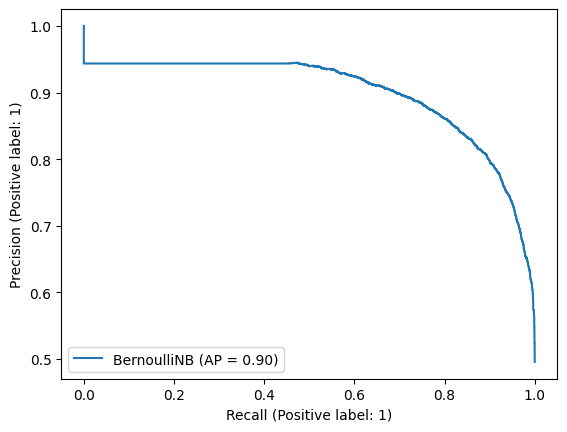

In [15]:
#predicting testing data by BernoulliNB

clfNB = BernoulliNB()
clfNB = clfNB.fit(X_train_tfidf, y_train)
testPred = clfNB.predict(X_test_tfidf)

NB_test_accuracy = clfNB.score(X_test_tfidf, y_test)
print("Test accuracy: "+"{:.2%}".format(NB_test_accuracy))
pretty_table.add_row(['Naive Bayes', round(NB_test_accuracy,2)])
PrecisionRecallDisplay.from_estimator(clfNB, X_test_tfidf, y_test)
plt.show()




Precision-Recall Curve, similar to ROC, 
showing the performance of the classification model at all thresholds.


In [16]:
#CrossValidation Niave Bayes

scoresCV = cross_val_score(estimator=BernoulliNB(), X=X_train_tfidf, y=y_train, cv=5) 

print("Cross Validation Scores Mean: "+"{:.2}".format(scoresCV.mean()))
print("Cross Validation Scores Std: "+"{:.2}".format(scoresCV.std()))

Cross Validation Scores Mean: 0.81
Cross Validation Scores Std: 0.0032


Trains and tests a model over multiple folds of the data. 
Yields model performance across the whole dataset vs. a single train-test split.

Below, doubling the cv level from 5 to 10 is a nominal change.

In [17]:
#cv=10

scoresCV = cross_val_score(estimator=BernoulliNB(), X=X_train_tfidf, y=y_train, cv=10) 

print("Cross Validation Scores Mean: "+"{:.2}".format(scoresCV.mean()))
print("Cross Validation Scores Std: "+"{:.2}".format(scoresCV.std()))

Cross Validation Scores Mean: 0.81
Cross Validation Scores Std: 0.0089


In [18]:
#Hyperparameter tuning Naive Bayes

pipe = Pipeline([("tfidf",TfidfVectorizer(stop_words="english")), ("nb", BernoulliNB())])

param_grid = [{"tfidf__min_df":[5, 20],
               "tfidf__ngram_range":[(1, 1), (1, 2), (1, 3), (1, 5), (1, 7)]}]
grid = GridSearchCV(estimator=pipe , param_grid =param_grid, cv=5) 
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', BernoulliNB())]),
             param_grid=[{'tfidf__min_df': [5, 20],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5),
                                                 (1, 7)]}])

In [19]:
grid.best_params_

{'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}

In [20]:
GSNB_train_accuracy = grid.score(X_train, y_train)
print("Tuned Train Accuracy: "+"{:.2%}".format(GSNB_train_accuracy))

Tuned Train Accuracy: 81.17%


In [21]:
GSNB_test_accuracy = grid.score(X_test, y_test)
pretty_table.add_row(['Grid Search NB', round(GSNB_test_accuracy,2)])
print("Tuned Test Accuracy: "+"{:.2%}".format(GSNB_test_accuracy))

Tuned Test Accuracy: 80.17%


Decision Trees

The random forest selects observations and creates many decision trees and the result is averaged. Text permutations can have many nuances which require a dynamic approach to find the best representation.

In [22]:
#Random Forest Decision Tree set

clfRF = RandomForestClassifier()
clfRF = clfRF.fit(X_train_tfidf, y_train)
rf_pred = clfRF.predict(X_test_tfidf)

RF_test_accuracy = accuracy_score(y_test,rf_pred)
pretty_table.add_row(['Random Forest', round(RF_test_accuracy,2)])
print("RF Test Accuracy: "+"{:.2%}".format(RF_test_accuracy))

RF Test Accuracy: 89.25%


In [23]:
#Cross Validation of Random Forest
rfc_cv_score = cross_val_score(clfRF, X_train_tfidf, y_train, cv=10, scoring='roc_auc')

In [24]:
cm = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix of y_train and rf_pred")
print(cm)
print('')
print("Classification of y_test, rf_pred")
print(classification_report(y_test, rf_pred))
print('')
print("All AUC Scores")
print(rfc_cv_score)
print('')

print("Average AUC Score of thresholds - Random Forest: ", rfc_cv_score.mean())

Confusion Matrix of y_train and rf_pred
[[3764  469]
 [ 433 3727]]

Classification of y_test, rf_pred
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4233
           1       0.89      0.90      0.89      4160

    accuracy                           0.89      8393
   macro avg       0.89      0.89      0.89      8393
weighted avg       0.89      0.89      0.89      8393


All AUC Scores
[0.9573147  0.95390644 0.94811786 0.96184794 0.94954539 0.95196959
 0.953023   0.95584304 0.95651139 0.95582843]

Average AUC Score of thresholds - Random Forest:  0.9543907783098513



As we do not want lean into bias with this analysis the AUC is not as important as the accuracy. Poisonous sentiment analysis with a bias could begin to unduly classify people. Accuracy is a better metric for balanced data. Though, considering the AUC that the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance might indicate a further investigation of positive verbosity compared the concerning class. Ranking outcomes into a multinomial structure might be the next step in this research.



Text(0.5, 1.0, 'Random Forest accuracy 89% \nTP 3741, FP 487, FN 418, TN 3747')

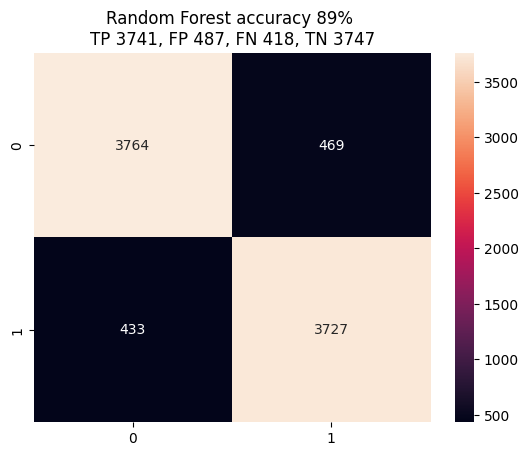

In [25]:
sns.heatmap(cm, annot=True, fmt='d').set_title('Random Forest accuracy 89% \nTP 3741, FP 487, FN 418, TN 3747')
      

Gradient Boosting classification 

Used for large datasets with binary targets by changing the regressor loss function from using the MSE to the log-likelihood. 

In [26]:
clfGB = GradientBoostingClassifier(n_estimators=100)
clfGB.fit(X_train_tfidf, y_train)
predGB_train = clfGB.predict(X_train_tfidf)
print(metrics.classification_report(y_train, predGB_train))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      9905
           1       0.91      0.83      0.87      9677

    accuracy                           0.88     19582
   macro avg       0.88      0.88      0.88     19582
weighted avg       0.88      0.88      0.88     19582



In [27]:
#Cross Validation of Gradient Boosting
cvScoreGB = cross_val_score(clfGB, X_train_tfidf, y_train, cv=10, scoring='roc_auc')


In [28]:
predGB_test = clfGB.predict(X_test_tfidf)
print("Confusion Matrix of Cross Validation of Gradient Boosting")
print(confusion_matrix(y_test, predGB_test))
print('')
print("Classification of Gradient Boosting")
print(classification_report(y_test, predGB_test))
print('')
print("All AUC Scores")
print(cvScoreGB)
print('')
print("Average AUC Score - GradientBoostingClassifier: ", cvScoreGB.mean())

GB_test_accuracy = accuracy_score(predGB_test,y_test)
pretty_table.add_row(['Gradient Boosting', round(GB_test_accuracy,2)])


Confusion Matrix of Cross Validation of Gradient Boosting
[[3862  371]
 [ 739 3421]]

Classification of Gradient Boosting
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4233
           1       0.90      0.82      0.86      4160

    accuracy                           0.87      8393
   macro avg       0.87      0.87      0.87      8393
weighted avg       0.87      0.87      0.87      8393


All AUC Scores
[0.94728226 0.93880357 0.93766129 0.94439563 0.93483596 0.9364132
 0.93900054 0.94452688 0.94404322 0.94023291]

Average AUC Score - GradientBoostingClassifier:  0.9407195464413363



The Extreme Gradient Boosting Classification

The XGB function fits a new predictor to the residual error from the previous predictor. In a sense, it is learning from its predecessors mistakes. To start the algorithm sets the log odds of the target feature at 0.5, and uses that value as a base to compute a probability of every instance. The algorithm then calculates the residuals, 
'observed value' - 'predicted value.'
At this point it creates a new decision tree and predicts the residuals given the previous residual standard error. XGB uses lambda in the denominator as a regularization parameter vs GB, which does not.
XGB has several optimization parameters, this works especially well for large datasets.



In [29]:
#XG Boost Classifier
modelXGB = XGBClassifier()
modelXGB.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

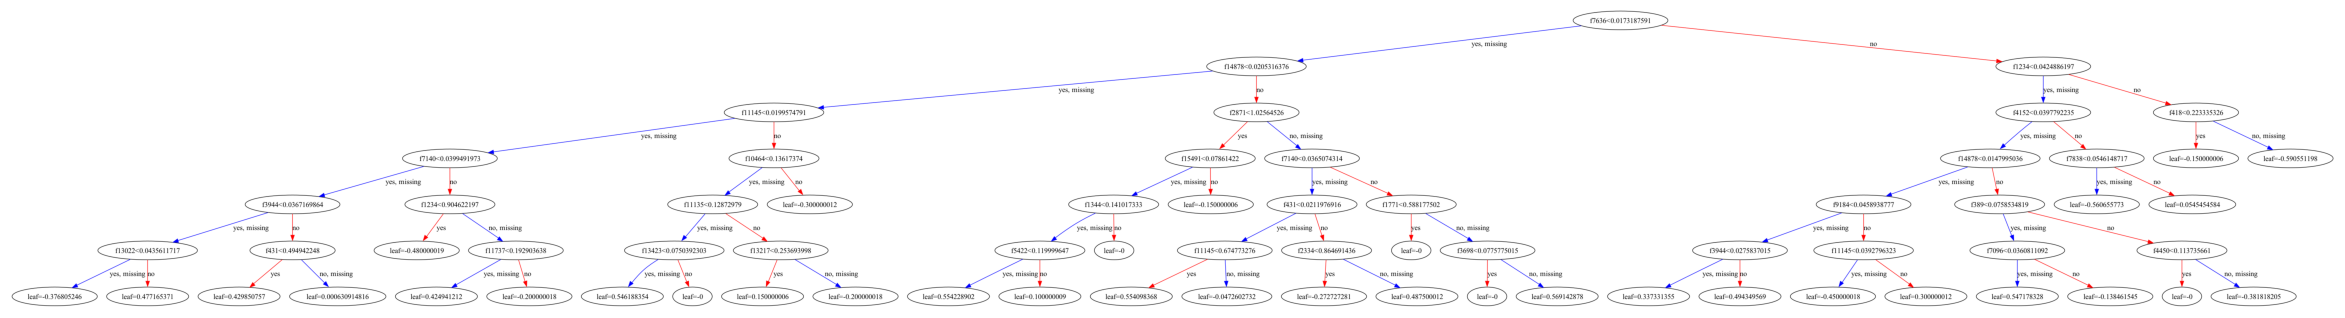

In [30]:
#For the visual of how tfidfVectorized data and the XGBClassifier interact
#see accompanying file
fig, ax = plt.subplots(figsize=(30, 40))
plot_tree(modelXGB, ax=ax)
plt.show()

In [31]:
# Predict class labels on test data
pred_teXGB = modelXGB.predict(X_test_tfidf)

In [32]:
# Basic info about the model
print('Tree Summary:')
print('No. of classes: ', modelXGB.n_classes_)
print('Classes: ', modelXGB.classes_)
print('No. of features: ', modelXGB.n_features_in_)
print('No. of Estimators: ', modelXGB.n_estimators)
print('--------------------------------------------------------')
print("")
print('Test Data:')
score_te = modelXGB.score(X_test_tfidf, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_teXGB))
print('--------------------------------------------------------')
print("")
pretty_table.add_row(['XG Boost', round(score_te,2)])


Tree Summary:
No. of classes:  2
Classes:  [0 1]
No. of features:  15844
No. of Estimators:  100
--------------------------------------------------------

Test Data:
Accuracy Score:  0.9012272131538187
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4233
           1       0.92      0.88      0.90      4160

    accuracy                           0.90      8393
   macro avg       0.90      0.90      0.90      8393
weighted avg       0.90      0.90      0.90      8393

--------------------------------------------------------



In [33]:
#select the best model to tune the hyperparameters: XGBoost

pretty_table

+-------------------+---------------+
|       Model       | Test Accuracy |
+-------------------+---------------+
|    Naive Bayes    |      0.8      |
|   Grid Search NB  |      0.8      |
|   Random Forest   |      0.89     |
| Gradient Boosting |      0.87     |
|      XG Boost     |      0.9      |
+-------------------+---------------+

In [34]:
#Hyperparameter tune XG Boost as best performing model
XGBpipe = Pipeline([("tfidf",TfidfVectorizer(stop_words="english")), ("XGB", XGBClassifier())])

params = {'XGB__max_depth':[None,0,5],
          'XGB__min_child_weight':[None,0,5],
         'XGB__reg_alpha':[0.001, 0.005, 0.01]}


grid = GridSearchCV(estimator=XGBpipe , param_grid = params, cv=5) 
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=Non...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'XGB__max_depth': [None, 0, 5],
                         'XGB__min_child_weight': [None, 0, 5],
                         'XGB__reg_alpha': [0.001, 0.005, 0.01]})

In [35]:
grid.best_params_

{'XGB__max_depth': None,
 'XGB__min_child_weight': None,
 'XGB__reg_alpha': 0.005}

In [36]:
grid.best_params_

final_test_accuracy = grid.score(X_test, y_test)
print("Final Test Accuracy: "+"{:.2%}".format(final_test_accuracy))

Final Test Accuracy: 90.08%


In [37]:
#XGBClassifier set_params manually so the plot can use it.

xgb_model = XGBClassifier(max_depth=None, min_child_weight=0, reg_alpha=0.001)
xgbParamsInc = xgb_model.fit(X_train_tfidf,y_train)


<AxesSubplot: >

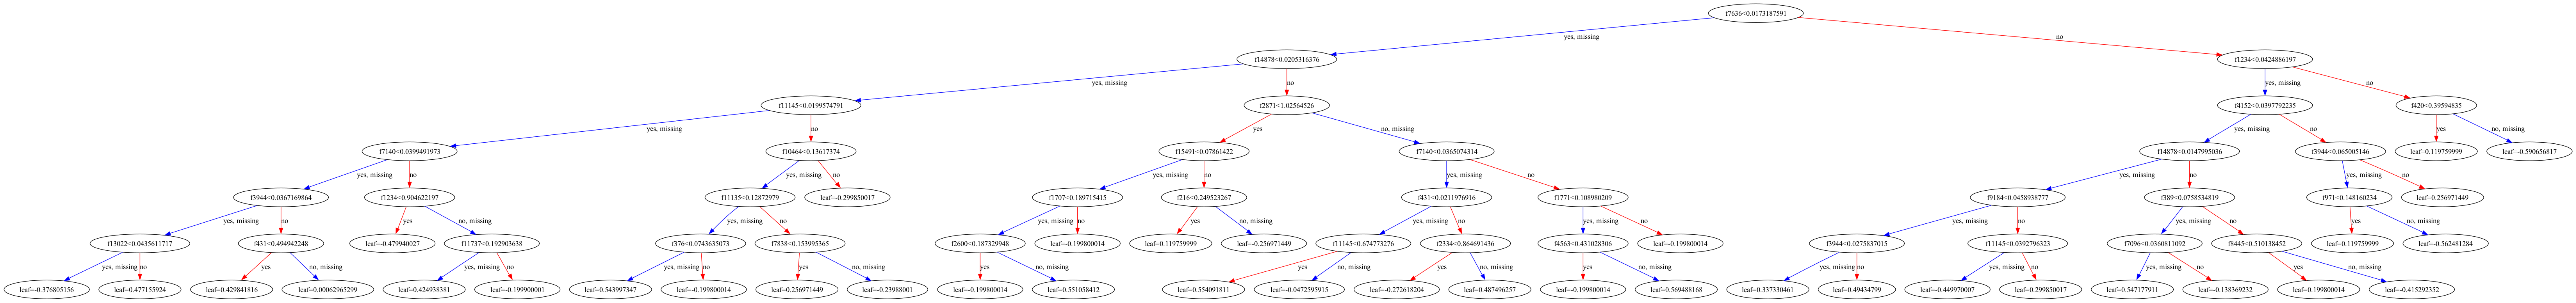

In [38]:
#For the visual of how tfidfVectorized data and the XGBClassifier interact
#see accompanying file

fig, ax = plt.subplots(figsize=(170, 170))
plot_tree(xgb_model, ax=ax)
#plt.savefig("XGBtreeTUNERegAlpha.pdf")

XGBoost predicts by the log-odds of the residuals. Each node predicts the next residual from the previous residual and itself and minimizes the log-loss function. 

Regularizing by lambda reduces the gain value and reduces overfitting from regression to classification.
Similarity score  = sum(residuals)/sum(prob*1-prob)+lambda
(change in difference) gain = sim(leftNode)+sim(rightNode)-sim(rootNode)

XGB with no parameters had an accuracy score of 90%, tuning three parameters resulted in a 2.7% improvement, this is good considering other tuning that has been done on this data only imporoved by 1/10 of a percent.   
max_depth sets the amount of details the algorithm uses. Too little information is underit, too much is over.
min_child_weight: limits the decision splitting to a significant threshold. 
reg_alpha is a regularization on the weights from a lasso regression. 

